In [17]:
# dependencies: tensorflow, numpy, opencv-python, matplotlib
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [18]:
print(os.getcwd())

/Users/gokulelangovan/Downloads/hack_ru_2025/hackru-s25-atop-the-stove/python_LLM_CV_integration


In [19]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, # scales the image pixel values to be between 0 and 1
    zoom_range = 0.2, # random zoom by 20%
    shear_range = 0.2, # distortion along one axis by up to 20%
    width_shift_range = 0.2, # left or right shift by 20%
    height_shift_range = 0.2, # up or down shift by 20%
    rotation_range = 25, # rotation +- 25 degrees
    horizontal_flip = True, # flips img horizontally 50% of the time
    fill_mode = 'nearest' # fill missing pixels with the nearest pixel
)
# the purpose of these alternations are to make the model more robust to different types of images

valid_datagen = ImageDataGenerator(rescale=1./255)
# scale the validation images to be between 0 and 1, no other augmentations for validation data

test_datagen = ImageDataGenerator(rescale=1./255)
# scale the validation images to be between 0 and 1, no other augmentations for test data

In [20]:
# load the data from the directories
# target size the typical size expected for CNN
# batch images in groups of 32
# there are 11 classes, i.e. types in the dataset
# use shuffle to randomize image order for training

train_dataset = train_datagen.flow_from_directory(
    './training',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
) 

valid_dataset = valid_datagen.flow_from_directory(
    './validation',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
) 

test_dataset = test_datagen.flow_from_directory(
    './evaluation',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [21]:
# confirm class order
print(train_dataset.class_indices)

{'Bread': 0, 'Dairy product': 1, 'Dessert': 2, 'Egg': 3, 'Fried food': 4, 'Meat': 5, 'Noodles-Pasta': 6, 'Rice': 7, 'Seafood': 8, 'Soup': 9, 'Vegetable-Fruit': 10}


In [ ]:
# create the model, using MobileNetV2 as the base model, removes layers of classification to create custom layers, fits to ccorrect image size
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# weights are not altered in training, we rather add custom layers to the model as we train
base_model.trainable = False

# ceate classification ustom layers
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x) # fully connected layer with 1024 neurons
x = layers.Dropout(0.5)(x) # dropout layer to prevent overfitting
x = layers.Dense(512, activation='relu')(x) # fully connected layer with 512 neurons
x = layers.Dropout(0.5)(x) # dropout layer to prevent overfitting
x = layers.Dense(11, activation='softmax')(x) # output layer with 11 neurons for 11 classes, converts outputs into class probabilities

model = tf.keras.Model(inputs=base_model.input, outputs=x) # create the model

In [22]:
# check for plateu in validation loss, reduce learning rate to 0.3 of original, if no improvement after 3 epochs
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3)

# compile the model, with multi-class classification, adam optimizier, and accuracy as the metric
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [24]:
# train the model, with 15 epochs, and the learning rate callback
# epoch is a single pass through the training dataset, there are 15 passes through the dataset
learning_model = model.fit(train_dataset, validation_data=valid_dataset, epochs=15, callbacks=[learning_rate])

Epoch 1/15
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.4891 - loss: 1.6040

/Users/gokulelangovan/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


309/309 ━━━━━━━━━━━━━━━━━━━━ 94s 295ms/step - accuracy: 0.4895 - loss: 1.6028 - val_accuracy: 0.7668 - val_loss: 0.7188 - learning_rate: 0.0010
Epoch 2/15
309/309 ━━━━━━━━━━━━━━━━━━━━ 92s 298ms/step - accuracy: 0.7081 - loss: 0.8946 - val_accuracy: 0.7971 - val_loss: 0.6237 - learning_rate: 0.0010
Epoch 3/15
309/309 ━━━━━━━━━━━━━━━━━━━━ 93s 299ms/step - accuracy: 0.7409 - loss: 0.7798 - val_accuracy: 0.7980 - val_loss: 0.6300 - learning_rate: 0.0010
Epoch 4/15
309/309 ━━━━━━━━━━━━━━━━━━━━ 91s 295ms/step - accuracy: 0.7517 - loss: 0.7679 - val_accuracy: 0.7985 - val_loss: 0.6317 - learning_rate: 0.0010
Epoch 5/15
309/309 ━━━━━━━━━━━━━━━━━━━━ 83s 268ms/step - accuracy: 0.7733 - loss: 0.7093 - val_accuracy: 0.8219 - val_loss: 0.5710 - learning_rate: 0.0010
Epoch 6/15
309/309 ━━━━━━━━━━━━━━━━━━━━ 77s 249ms/step - accuracy: 0.7838 - loss: 0.6826 - val_accuracy: 0.8198 - val_loss: 0.5817 - learning_rate: 0.0010
Epoch 7/15
309/309 ━━━━━━━━━━━━━━━━━━━━ 73s 235ms/step - accuracy: 0.7896 - loss:

In [25]:
model.save('initial_model.h5')

In [26]:
# fine-tuning the model, unfreeze the base model to permit chanes in all layers, and recompile the model once more
base_model.trainable = True

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics = ['accuracy']
)

In [27]:
# finetune using 20 epochs, passsing through the validation dataset
tuned_learning_model = model.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=[learning_rate])
# original epoch = 25

Epoch 1/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 261s 818ms/step - accuracy: 0.5816 - loss: 1.7111 - val_accuracy: 0.8423 - val_loss: 0.5310 - learning_rate: 1.0000e-05
Epoch 2/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 256s 828ms/step - accuracy: 0.7537 - loss: 0.7589 - val_accuracy: 0.8469 - val_loss: 0.5166 - learning_rate: 1.0000e-05
Epoch 3/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 249s 804ms/step - accuracy: 0.7884 - loss: 0.6475 - val_accuracy: 0.8455 - val_loss: 0.5097 - learning_rate: 1.0000e-05
Epoch 4/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 251s 813ms/step - accuracy: 0.8172 - loss: 0.5745 - val_accuracy: 0.8472 - val_loss: 0.4851 - learning_rate: 1.0000e-05
Epoch 5/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 253s 817ms/step - accuracy: 0.8159 - loss: 0.5541 - val_accuracy: 0.8472 - val_loss: 0.4709 - learning_rate: 1.0000e-05
Epoch 6/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 257s 831ms/step - accuracy: 0.8377 - loss: 0.5076 - val_accuracy: 0.8522 - val_loss: 0.4641 - learning_rate: 1.0000e-05
Epoch 7/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 

In [28]:
model.save('tuned_model.h5')

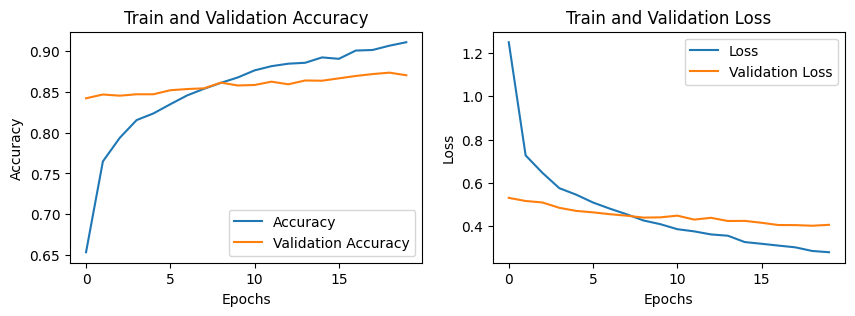

In [29]:
# visualize the difference accross training and validation data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.title('Train and Validation Accuracy')
plt.plot(tuned_learning_model.history['accuracy'], label='Accuracy')
plt.plot(tuned_learning_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Train and Validation Loss')
plt.plot(tuned_learning_model.history['loss'], label='Loss')
plt.plot(tuned_learning_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# generally, accuracy increases and loss decreases as the model trains
# loss signifies how far the model is from the expected labels, smaler loss is better

In [30]:
# evaluate the model on the training and validation datasets to assess performance
result_train = model.evaluate(train_dataset)
result_val = model.evaluate(valid_dataset)

print('Train Dataset Accuracy: ', result_train[1])
print('Train Dataset Loss: ', result_train[0])
print('-' * 40)

print('Validation Dataset Accuracy: ', result_val[1])
print('Validation Dataset Loss: ', result_val[0])
print('-' * 40)

309/309 ━━━━━━━━━━━━━━━━━━━━ 57s 186ms/step - accuracy: 0.9536 - loss: 0.1513
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.8700 - loss: 0.3995
Train Dataset Accuracy:  0.9509426355361938
Train Dataset Loss:  0.15619337558746338
----------------------------------------
Validation Dataset Accuracy:  0.8705539107322693
Validation Dataset Loss:  0.40658822655677795
----------------------------------------
